# Search-3-Informed : Algorithmes de Recherche Informee

**Navigation** : [<< Recherche non informee](Search-2-Uninformed.ipynb) | [Index](../README.md) | [Recherche locale >>](Search-4-LocalSearch.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Distinguer** recherche informee et non informee (role des heuristiques)
2. **Implementer** l'algorithme A* et ses variantes (Greedy, IDA*)
3. **Concevoir** des heuristiques admissibles et consistantes
4. **Analyser** les proprietes de completude, optimalite et complexite
5. **Comparer** experimentalement les performances sur des problemes concrets

### Prerequis
- Notebook Search-2-Uninformed (BFS, DFS, UCS, notion de frontiere)
- Bases de Python : classes, heapq, comprehension de listes

### Duree estimee : 50 minutes

In [1]:
# Imports
import sys
import time
import heapq
import math
from collections import deque
from typing import Optional, List, Dict, Tuple, Any, Callable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import pandas as pd

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Utilitaires de visualisation depuis le dossier parent
sys.path.insert(0, '..')
from search_helpers import benchmark_table, plot_benchmark

print("Environnement pret pour la recherche informee.")

Environnement pret pour la recherche informee.


## 1. Introduction : Qu'est-ce que la recherche informee ?

### Recherche non informee vs informee

Les algorithmes de recherche **non informee** (BFS, DFS, UCS, IDDFS) explorent l'espace de recherche sans connaissance specifique du probleme. Ils traitent tous les etats de maniere equivalente.

La recherche **informee** utilise une **heuristique** $h(n)$ qui estime le cout restant pour atteindre le but depuis l'etat $n$. Cette connaissance guide la recherche vers les regions prometteuses de l'espace.

| Aspect | Recherche non informee | Recherche informee |
|--------|----------------------|-------------------|
| Information | Uniquement la structure du graphe | + Heuristique $h(n)$ |
| Strategie | Exploration systematique | Guidee vers le but |
| Efficacite | Souvent exponentielle | Beaucoup plus efficace si bonne heuristique |
| Exemples | BFS, DFS, UCS, IDDFS | Greedy, A*, IDA* |

### Qu'est-ce qu'une heuristique ?

Une **heuristique** $h(n)$ est une fonction d'estimation qui :
- **Estime** le cout restant de $n$ au but
- **Doit etre** rapide a calculer (pas de recherche complete !)
- **Peut etre** optimiste (sous-estimation) ou pessimiste (sur-estimation)

> **Mnemonic** : "Heuristique" vient du grec *heuriskein* = "trouver". C'est une regle pratique pour trouver des solutions, pas une garantie mathematique.

### Exemples d'heuristiques

| Probleme | Etat | But | Heuristique $h(n)$ |
|----------|------|-----|------------------|
| 8-puzzle | Configuration actuelle | Configuration triee | Tuiles mal placees ou distance Manhattan |
| Itineraire | Ville actuelle | Ville destination | Distance a vol d'oiseau |
| Jeu de taquin | Etat du plateau | Etat resolu | Nombre de pieces hors place |

Ce notebook detaille ces exemples et implemente les algorithmes qui exploitent ces heuristiques.

## 2. Cadre generique pour la recherche informee

### Rappel : Structure de noeud

Nous utilisons la meme structure `Node` que dans Search-2, avec une possibilite de stocker les valeurs heuristiques.

In [2]:
# --- Classe Node (etendue pour les heuristiques) ---

class Node:
    """Noeud dans l'arbre de recherche avec support heuristique."""

    def __init__(self, state, parent=None, action=None, path_cost=0, h=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost  # g(n) : cout du chemin depuis le depart
        self.h = h                  # h(n) : estimation heuristique du reste
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    @property
    def f(self):
        """f(n) = g(n) + h(n) : estimation totale du cout."""
        return self.path_cost + self.h

    def expand(self, problem, heuristic_func=None):
        """Genere les noeuds fils en appliquant toutes les actions possibles."""
        children = []
        for action in problem.actions(self.state):
            next_state = problem.result(self.state, action)
            cost = problem.step_cost(self.state, action, next_state)
            h = heuristic_func(next_state) if heuristic_func else 0
            child = Node(next_state, parent=self, action=action,
                         path_cost=self.path_cost + cost, h=h)
            children.append(child)
        return children

    def path(self):
        """Retourne la liste des noeuds de la racine a ce noeud."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def solution(self):
        """Retourne la sequence d'actions de la racine a ce noeud."""
        return [node.action for node in self.path()[1:]]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

    def __lt__(self, other):
        """Comparaison pour la file de priorite (par f, puis par h)."""
        return self.f < other.f

    def __repr__(self):
        return f"Node({self.state}, g={self.path_cost}, h={self.h}, f={self.f:.1f})"


# --- Classe Problem abstraite ---

class Problem:
    """Classe abstraite definissant un probleme de recherche."""

    def __init__(self, initial, goal=None):
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Actions possibles depuis cet etat."""
        raise NotImplementedError

    def result(self, state, action):
        """Etat resultant de l'application de l'action."""
        raise NotImplementedError

    def goal_test(self, state):
        """Teste si l'etat est un etat but."""
        return state == self.goal

    def step_cost(self, state, action, next_state):
        """Cout d'une action. Par defaut, cout uniforme de 1."""
        return 1


# --- Classe de resultat pour les statistiques ---

class SearchResult:
    """Resultat d'une recherche, avec statistiques."""

    def __init__(self, algorithm, solution_node=None, nodes_expanded=0,
                 nodes_generated=0, max_frontier_size=0, elapsed_ms=0,
                 explored_order=None, heuristic_name=""):
        self.algorithm = algorithm
        self.solution_node = solution_node
        self.nodes_expanded = nodes_expanded
        self.nodes_generated = nodes_generated
        self.max_frontier_size = max_frontier_size
        self.elapsed_ms = elapsed_ms
        self.explored_order = explored_order or []
        self.heuristic_name = heuristic_name

    @property
    def found(self):
        return self.solution_node is not None

    @property
    def path(self):
        if self.solution_node:
            return [n.state for n in self.solution_node.path()]
        return []

    @property
    def cost(self):
        if self.solution_node:
            return self.solution_node.path_cost
        return float('inf')

    def display(self):
        heur_str = f" [{self.heuristic_name}]" if self.heuristic_name else ""
        print(f"\n--- {self.algorithm}{heur_str} ---")
        if self.found:
            print(f"  Chemin     : {' -> '.join(self.path)}")
            print(f"  Cout total : {self.cost}")
            print(f"  Longueur   : {len(self.path) - 1} etapes")
        else:
            print(f"  Aucune solution trouvee.")
        print(f"  Noeuds explores  : {self.nodes_expanded}")
        print(f"  Noeuds generes   : {self.nodes_generated}")
        print(f"  Frontiere max    : {self.max_frontier_size}")
        print(f"  Temps            : {self.elapsed_ms:.2f} ms")


print("Framework de recherche informee pret.")

Framework de recherche informee pret.


### Probleme de reference : Graphe pondere

Pour comparer les algorithmes, utilisons un probleme d'itineraire sur un graphe de villes. Ce probleme permet d'illustrer clairement la difference entre cout reel et estimation heuristique.

In [3]:
# --- Probleme de recherche sur un graphe (villes et routes) ---

class GraphProblem(Problem):
    """Probleme de cheminement sur un graphe pondere."""

    def __init__(self, initial, goal, graph):
        """
        Args:
            initial: noeud de depart
            goal: noeud d'arrivee
            graph: dict de dict {noeud: {voisin: distance, ...}, ...}
        """
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, state):
        return list(self.graph.get(state, {}).keys())

    def result(self, state, action):
        return action

    def step_cost(self, state, action, next_state):
        return self.graph[state].get(next_state, float('inf'))


# --- Graphe des villes francaises ---

france_graph = {
    'Paris':      {'Lyon': 465, 'Lille': 225, 'Strasbourg': 490, 'Nantes': 385, 'Bordeaux': 585},
    'Lyon':       {'Paris': 465, 'Marseille': 315, 'Grenoble': 110, 'Strasbourg': 490},
    'Marseille':  {'Lyon': 315, 'Toulouse': 405, 'Nice': 200, 'Montpellier': 170},
    'Toulouse':   {'Marseille': 405, 'Bordeaux': 245, 'Montpellier': 245},
    'Bordeaux':   {'Paris': 585, 'Toulouse': 245, 'Nantes': 340},
    'Nantes':     {'Paris': 385, 'Bordeaux': 340, 'Rennes': 110},
    'Rennes':     {'Nantes': 110, 'Lille': 600},
    'Lille':      {'Paris': 225, 'Rennes': 600, 'Strasbourg': 530},
    'Strasbourg': {'Paris': 490, 'Lyon': 490, 'Lille': 530},
    'Nice':       {'Marseille': 200, 'Grenoble': 330},
    'Grenoble':   {'Lyon': 110, 'Nice': 330},
    'Montpellier': {'Marseille': 170, 'Toulouse': 245},
}

# Coordonnees pour la visualisation
france_coords = {
    'Paris': (2.35, 48.86), 'Lyon': (4.83, 45.76), 'Marseille': (5.37, 43.30),
    'Toulouse': (1.44, 43.60), 'Bordeaux': (-0.57, 44.84), 'Nantes': (-1.55, 47.22),
    'Rennes': (-1.68, 48.11), 'Lille': (3.06, 50.63), 'Strasbourg': (7.75, 48.57),
    'Nice': (7.26, 43.70), 'Grenoble': (5.72, 45.19), 'Montpellier': (3.88, 43.61),
}

# Probleme de reference : Bordeaux -> Strasbourg
problem_bs = GraphProblem('Bordeaux', 'Strasbourg', france_graph)

print("Graphe des villes francaises charge.")
print(f"  {len(france_graph)} villes, {sum(len(v) for v in france_graph.values()) // 2} routes")
print(f"  Probleme de reference : {problem_bs.initial} -> {problem_bs.goal}")

Graphe des villes francaises charge.
  12 villes, 18 routes
  Probleme de reference : Bordeaux -> Strasbourg


### Definition d'une heuristique pour le graphe

Pour un probleme d'itineraire, une heuristique naturelle est la **distance a vol d'oiseau** (distance euclidienne) entre les villes. Cette heuristique est :

In [4]:
# --- Heuristique de distance a vol d'oiseau ---

def euclidean_distance(city1, city2, coords):
    """Distance euclidienne entre deux villes (approximation vol d'oiseau)."""
    x1, y1 = coords[city1]
    x2, y2 = coords[city2]
    # Conversion approximative : 1 degre lat ~ 111 km
    lat_scale = 111.0
    lon_scale = 80.0  # Approximatif a la latitude de la France
    return math.sqrt(((x2 - x1) * lon_scale)**2 + ((y2 - y1) * lat_scale)**2)


def make_heuristic(goal, coords):
    """Fabrique une fonction heuristique pour un but donne."""
    def h(state):
        return euclidean_distance(state, goal, coords)
    return h


# Heuristique pour notre probleme
h_to_strasbourg = make_heuristic('Strasbourg', france_coords)

# Exemple d'utilisation
print("Heuristique h(n) = distance a vol d'oiseau vers Strasbourg")
print("=" * 55)
for city in ['Bordeaux', 'Paris', 'Lyon', 'Nice']:
    h_val = h_to_strasbourg(city)
    real_cost = problem_bs.step_cost(city, 'Strasbourg', 'Strasbourg') if city in france_graph and 'Strasbourg' in france_graph[city] else 'N/A'
    print(f"  {city:<12} h(n)={h_val:6.0f} km  (cout reel: {real_cost})")

print("\nNote : h(n) <= cout reel dans tous les cas -> heuristique admissible !")

Heuristique h(n) = distance a vol d'oiseau vers Strasbourg
  Bordeaux     h(n)=   784 km  (cout reel: N/A)
  Paris        h(n)=   433 km  (cout reel: 490)
  Lyon         h(n)=   390 km  (cout reel: 490)
  Nice         h(n)=   542 km  (cout reel: N/A)

Note : h(n) <= cout reel dans tous les cas -> heuristique admissible !


## 3. Greedy Best-First Search

### Principe

Le **Greedy Best-First Search** (recherche gloutonne) explore toujours le noeud ayant la **plus petite valeur heuristique** $h(n)$. Il "fonce" vers le but sans considerer le cout deja depense.

- **Critere d'expansion** : minimiser $h(n)$ uniquement
- **Intuition** : le noeud le plus proche du but (estimation) est explore en premier
- **Risque** : peut suivre un chemin看起来 prometteur mais qui mene a une impasse

### Proprietes theoriques

| Propriete | Valeur | Condition |
|-----------|--------|----------|
| Completude | Non | Peut boucler dans les graphes finis |
| Optimalite | Non | Minimise $h(n)$, pas le cout reel |
| Complexite temporelle | $O(b^m)$ | Pire cas |
| Complexite spatiale | $O(b^m)$ | Pire cas |

En pratique, Greedy est souvent tres rapide mais ne garantit pas la qualite de la solution.

In [5]:
def greedy_best_first_search(problem, heuristic, verbose=False):
    """
    Recherche gloutonne (Greedy Best-First).
    Frontiere = file de priorite par h(n) uniquement.
    """
    start_time = time.perf_counter()

    h_init = heuristic(problem.initial)
    node = Node(problem.initial, h=h_init)

    if problem.goal_test(node.state):
        elapsed = (time.perf_counter() - start_time) * 1000
        return SearchResult('Greedy', node, 0, 0, 1, elapsed,
                            heuristic_name=heuristic.__name__)

    # Frontiere : min-heap par h(n)
    frontier = []
    counter = 0
    heapq.heappush(frontier, (node.h, counter, node))
    counter += 1
    frontier_states = {node.state: node.h}

    explored = set()
    explored_order = []
    nodes_expanded = 0
    nodes_generated = 0
    max_frontier = 1

    while frontier:
        h_val, _, current = heapq.heappop(frontier)

        # Ignorer si on a trouve un meilleur chemin vers cet etat
        if current.state in explored:
            continue

        if problem.goal_test(current.state):
            elapsed = (time.perf_counter() - start_time) * 1000
            explored_order.append(current.state)
            return SearchResult('Greedy', current, nodes_expanded,
                                nodes_generated, max_frontier,
                                elapsed, explored_order,
                                heuristic.__name__)

        explored.add(current.state)
        explored_order.append(current.state)
        nodes_expanded += 1

        if verbose:
            print(f"  Explore: {current.state:15s} h={current.h:6.0f} | "
                  f"Frontiere: {len(frontier)} noeuds")

        for child in current.expand(problem, heuristic):
            nodes_generated += 1
            if child.state not in explored:
                old_h = frontier_states.get(child.state, float('inf'))
                if child.h < old_h:
                    heapq.heappush(frontier, (child.h, counter, child))
                    counter += 1
                    frontier_states[child.state] = child.h
                    max_frontier = max(max_frontier, len(frontier))

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('Greedy', None, nodes_expanded, nodes_generated,
                        max_frontier, elapsed, explored_order,
                        heuristic.__name__)


print("Algorithme Greedy Best-First implemente.")

Algorithme Greedy Best-First implemente.


In [6]:
# --- Test de Greedy sur le probleme Bordeaux -> Strasbourg ---

print("Greedy Best-First : Bordeaux -> Strasbourg")
print("=" * 60)
result_greedy = greedy_best_first_search(problem_bs, h_to_strasbourg, verbose=True)
result_greedy.display()

Greedy Best-First : Bordeaux -> Strasbourg
  Explore: Bordeaux        h=   784 | Frontiere: 0 noeuds
  Explore: Paris           h=   433 | Frontiere: 2 noeuds

--- Greedy [h] ---
  Chemin     : Bordeaux -> Paris -> Strasbourg
  Cout total : 1075
  Longueur   : 2 etapes
  Noeuds explores  : 2
  Noeuds generes   : 8
  Frontiere max    : 5
  Temps            : 0.08 ms


### Interpretation : Comportement de Greedy

**Sortie obtenue** : Greedy explore en priorite les villes les plus proches de Strasbourg a vol d'oiseau.

| Aspect | Observation |
|--------|-------------|
| Strategie | Explore d'abord les villes avec $h(n)$ minimal |
| Premieres villes explorees | Celles situees geographiquement pres de Strasbourg |
| Comportement typique | Suit une ligne "droite" vers le but |

**Points cles** :
1. Greedy ignore le cout deja depense ($g(n)$)
2. Il peut trouver une solution rapidement, mais pas forcement optimale
3. Sur notre graphe, il peut suivre un chemin qui semble bon geometriquement mais est plus long en distance reelle

## 4. A* Search (A-Star)

### Principe

L'algorithme **A*** combine le cout deja depense $g(n)$ et l'estimation heuristique $h(n)$ en une seule fonction d'evaluation :

$$f(n) = g(n) + h(n)$$

- $g(n)$ : cout du chemin depuis l'etat initial (exact, connu)
- $h(n)$ : estimation du cout restant jusqu'au but (heuristique)
- $f(n)$ : estimation du cout total d'un chemin passant par $n$

**A* explore le noeud avec le plus petit $f(n)$**, equilibrant ainsi :
- Le cout deja engage (ne pas abandonner un chemin prometteur)
- Le potentiel futur (s'orienter vers le but)

### Proprietes theoriques

| Propriete | Valeur | Condition |
|-----------|--------|----------|
| Completude | Oui | Si $b$ est fini et les couts > 0 |
| Optimalite | Oui | Si $h$ est **admissible** |
| Optimalite | Oui | Si $h$ est **consistante** (et Graph-Search) |
| Complexite | $O(b^d)$ | Exponentielle, avec une constante plus petite que les algorithmes non informes |

### Definitions cles

| Terme | Definition |
|-------|------------|
| **Admissible** | $h(n) \leq h^*(n)$ pour tout $n$ (ne surestime jamais le cout reel) |
| **Consistante** | $h(n) \leq c(n, a, n') + h(n')$ pour tout voisin $n'$ (monotone) |
| $h^*(n)$ | Cout optimal reel de $n$ au but |

> **Theoreme** : Si $h$ est consistante, alors A* est optimal et n'expand jamais un noeud qui a deja ete explore (pas besoin de re-open).

In [7]:
def a_star_search(problem, heuristic, verbose=False):
    """
    Algorithme A* (Graph-Search).
    Frontiere = file de priorite par f(n) = g(n) + h(n).
    """
    start_time = time.perf_counter()

    h_init = heuristic(problem.initial)
    node = Node(problem.initial, h=h_init)

    if problem.goal_test(node.state):
        elapsed = (time.perf_counter() - start_time) * 1000
        return SearchResult('A*', node, 0, 0, 1, elapsed,
                            heuristic_name=heuristic.__name__)

    # Frontiere : min-heap par f(n)
    frontier = []
    counter = 0
    heapq.heappush(frontier, (node.f, counter, node))
    counter += 1

    # Pour chaque etat, on garde le meilleur cout g trouve
    g_scores = {node.state: 0}  # g_score[state] = meilleur g(n) connu

    explored = set()
    explored_order = []
    nodes_expanded = 0
    nodes_generated = 0
    max_frontier = 1

    while frontier:
        f_val, _, current = heapq.heappop(frontier)

        # Si c'est le meilleur chemin vers cet etat
        if current.state in explored:
            continue

        if problem.goal_test(current.state):
            elapsed = (time.perf_counter() - start_time) * 1000
            explored_order.append(current.state)
            return SearchResult('A*', current, nodes_expanded,
                                nodes_generated, max_frontier,
                                elapsed, explored_order,
                                heuristic.__name__)

        explored.add(current.state)
        explored_order.append(current.state)
        nodes_expanded += 1

        if verbose:
            print(f"  Explore: {current.state:15s} g={current.path_cost:6.0f} "
                  f"h={current.h:6.0f} f={current.f:7.0f} | Frontiere: {len(frontier)}")

        for child in current.expand(problem, heuristic):
            nodes_generated += 1
            if child.state not in explored:
                # On n'ajoute que si on a ameliore le g_score
                old_g = g_scores.get(child.state, float('inf'))
                if child.path_cost < old_g:
                    g_scores[child.state] = child.path_cost
                    heapq.heappush(frontier, (child.f, counter, child))
                    counter += 1
                    max_frontier = max(max_frontier, len(frontier))

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('A*', None, nodes_expanded, nodes_generated,
                        max_frontier, elapsed, explored_order,
                        heuristic.__name__)


print("Algorithme A* implemente.")

Algorithme A* implemente.


In [8]:
# --- Test de A* sur le probleme Bordeaux -> Strasbourg ---

print("A* : Bordeaux -> Strasbourg")
print("=" * 60)
result_astar = a_star_search(problem_bs, h_to_strasbourg, verbose=True)
result_astar.display()

A* : Bordeaux -> Strasbourg
  Explore: Bordeaux        g=     0 h=   784 f=    784 | Frontiere: 0
  Explore: Toulouse        g=   245 h=   748 f=    993 | Frontiere: 2
  Explore: Paris           g=   585 h=   433 f=   1018 | Frontiere: 3

--- A* [h] ---
  Chemin     : Bordeaux -> Paris -> Strasbourg
  Cout total : 1075
  Longueur   : 2 etapes
  Noeuds explores  : 3
  Noeuds generes   : 11
  Frontiere max    : 6
  Temps            : 0.10 ms


### Interpretation : A* equilibre g et h

**Sortie obtenue** : A* explore en considerant a la fois le cout deja depense ($g$) et l'estimation future ($h$).

| Algorithme | Critere d'expansion | Comportement |
|------------|-------------------|--------------|
| Greedy | $h(n)$ seulement | Fonce vers le but |
| A* | $f(n) = g(n) + h(n)$ | Equilibre cout passe et futur |

**Points cles** :
1. A* garantit une **solution optimale** si $h$ est admissible
2. Les valeurs $f(n)$ indiquent l'estimation du cout total de chaque chemin
3. Le nombre de noeuds explores est generalement bien inferieur a BFS/UCS

### Comparaison Greedy vs A*

Comparons les deux algorithmes sur le meme probleme pour observer leurs differences de comportement et de performance.

In [9]:
# --- Comparaison Greedy vs A* ---

print("Comparaison : Greedy vs A*")
print("=" * 70)

# Re-exécuter pour avoir les resultats frais
result_greedy = greedy_best_first_search(problem_bs, h_to_strasbourg)
result_astar = a_star_search(problem_bs, h_to_strasbourg)

# Tableau comparatif
comparison_df = pd.DataFrame([
    {
        'Algorithme': 'Greedy',
        'Chemin': ' -> '.join(result_greedy.path),
        'Cout (km)': result_greedy.cost,
        'Longueur': len(result_greedy.path) - 1,
        'Noeuds explores': result_greedy.nodes_expanded,
        'Temps (ms)': f"{result_greedy.elapsed_ms:.2f}",
    },
    {
        'Algorithme': 'A*',
        'Chemin': ' -> '.join(result_astar.path),
        'Cout (km)': result_astar.cost,
        'Longueur': len(result_astar.path) - 1,
        'Noeuds explores': result_astar.nodes_expanded,
        'Temps (ms)': f"{result_astar.elapsed_ms:.2f}",
    },
])

print(comparison_df.to_string(index=False))

print("\n" + "=" * 70)
if result_greedy.cost <= result_astar.cost:
    print("NOTE : Greedy a trouve un chemin de meme cout qu'A* (coincidence !)")
else:
    diff = result_greedy.cost - result_astar.cost
    pct = (diff / result_astar.cost) * 100
    print(f"Greedy a trouve un chemin {diff:.0f} km plus long ({pct:.1f}% de plus).")

Comparaison : Greedy vs A*
Algorithme                          Chemin  Cout (km)  Longueur  Noeuds explores Temps (ms)
    Greedy Bordeaux -> Paris -> Strasbourg       1075         2                2       0.06
        A* Bordeaux -> Paris -> Strasbourg       1075         2                3       0.05

NOTE : Greedy a trouve un chemin de meme cout qu'A* (coincidence !)


### Interpretation : Greedy n'est pas optimal

**Sortie obtenue** : Le tableau compare les resultats de Greedy et A*.

| Aspect | Greedy | A* |
|--------|--------|-----|
| Optimalite | Non garanti | Garanti (avec heuristique admissible) |
| Noeuds explores | Generalement moins | Peut etre plus |
| Qualite solution | Variable | Toujours optimale |

**Lecon fondamentale** : Greedy peut etre plus rapide mais risque de trouver une solution sous-optimale. A* est un peu plus coûteux en exploration mais garantit l'optimalite.

## 5. IDA* (Iterative Deepening A*)

### Principe

**IDA*** est la version iterative deepening de A*. Il execute des DFS limites par une borne sur $f(n)$ (plutot que sur la profondeur).

A chaque iteration :
1. DFS avec une limite $f_{\text{limit}}$
2. Si un noeud a $f(n) > f_{\text{limit}}$, on le `` coupe''
3. La prochaine iteration utilise $f_{\text{limit}} = \min\{f(n) \mid n \text{ coupe}\}$

### Pourquoi IDA* ?

| Avantage | Explication |
|-----------|-------------|
| Memoire | $O(bd)$ au lieu de $O(b^d)$ pour A* |
| Pas de file de priorite | DFS recursif plus simple |
| Meme optimalite | A* avec la meme heuristique |

**Inconvenient** : Re-explore les noeuds a chaque iteration (comme IDDFS), mais l'overhead est modeste.

In [10]:
def ida_star_search(problem, heuristic, max_iterations=1000, verbose=False):
    """
    IDA* : Iterative Deepening A*.
    DFS avec limites sur f(n) = g(n) + h(n).
    """
    start_time = time.perf_counter()

    bound = heuristic(problem.initial)  # Premiere borne = h(initial)
    root = Node(problem.initial, h=bound)

    total_expanded = 0
    total_generated = 0
    explored_order = []
    iterations = 0

    def search(node, bound, min_excess):
        """
        DFS recursif avec limite sur f(n).
        Retourne (solution_node, new_bound).
        """
        nonlocal total_expanded, total_generated

        f = node.f
        if f > bound:
            return None, f  # Coupe : retourner le f qui a provoque la coupure

        if problem.goal_test(node.state):
            return node, bound

        total_expanded += 1
        min_next_bound = float('inf')

        for child in node.expand(problem, heuristic):
            total_generated += 1
            result, child_bound = search(child, bound, min_next_bound)

            if result is not None:
                return result, bound

            min_next_bound = min(min_next_bound, child_bound)

        return None, min_next_bound

    # Boucle principale avec bornes croissantes
    while iterations < max_iterations:
        iterations += 1

        if verbose:
            print(f"  Iteration {iterations}: bound = {bound:.0f}")

        result, new_bound = search(root, bound, float('inf'))

        if result is not None:
            elapsed = (time.perf_counter() - start_time) * 1000
            # Reconstruire l'ordre d'exploration (approximatif)
            return SearchResult('IDA*', result, total_expanded,
                                total_generated, iterations,
                                elapsed, explored_order,
                                heuristic.__name__)

        if new_bound == float('inf'):
            break  # Espace entier explore

        bound = new_bound

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('IDA*', None, total_expanded, total_generated,
                        0, elapsed, explored_order,
                        heuristic.__name__)


print("Algorithme IDA* implemente.")

Algorithme IDA* implemente.


In [11]:
# --- Test de IDA* sur le probleme Bordeaux -> Strasbourg ---

print("IDA* : Bordeaux -> Strasbourg")
print("=" * 60)
result_idastar = ida_star_search(problem_bs, h_to_strasbourg, verbose=True)
result_idastar.display()

IDA* : Bordeaux -> Strasbourg
  Iteration 1: bound = 784
  Iteration 2: bound = 993
  Iteration 3: bound = 1018
  Iteration 4: bound = 1075

--- IDA* [h] ---
  Chemin     : Bordeaux -> Paris -> Strasbourg
  Cout total : 1075
  Longueur   : 2 etapes
  Noeuds explores  : 8
  Noeuds generes   : 24
  Frontiere max    : 4
  Temps            : 0.12 ms


### Interpretation : IDA* et les bornes croissantes

**Sortie obtenue** : IDA* effectue plusieurs iterations avec des bornes $f_{\text{limit}}$ croissantes.

| Iteration | Borne $f_{\text{limit}}$ | Comportement |
|-----------|------------------------|--------------|
| 1 | $h(\text{initial})$ | Coupe tot, augmenter la borne |
| 2 | $\min\{f\text{ coupes}\}$ | Coupe encore, augmenter |
| ... | ... | ... |
| k | $\geq f(\text{solution})$ | Solution trouvee ! |

**Points cles** :
1. IDA* trouve la **meme solution** que A* (optimalite garantie)
2. Utilise **beaucoup moins de memoire** que A* ($O(bd)$ vs $O(b^d)$)
3. L'overhead de re-exploration est acceptable car la borne augmente rapidement

### Comparaison complete : Greedy vs A* vs IDA*

Comparons les trois algorithmes informes sur plusieurs problemes pour observer leurs comportements relatifs.

In [12]:
# --- Comparaison sur plusieurs problemes ---

test_cases = [
    ('Bordeaux', 'Strasbourg'),
    ('Rennes', 'Nice'),
    ('Lille', 'Toulouse'),
    ('Nantes', 'Marseille'),
]

all_results = []

for start, goal in test_cases:
    problem = GraphProblem(start, goal, france_graph)
    h = make_heuristic(goal, france_coords)

    greedy = greedy_best_first_search(problem, h)
    astar = a_star_search(problem, h)
    idastar = ida_star_search(problem, h)

    all_results.append({
        'start': start,
        'goal': goal,
        'greedy': greedy,
        'astar': astar,
        'idastar': idastar,
    })

# Tableau recapitulatif
print("Comparaison des algorithmes informes")
print("=" * 90)

for r in all_results:
    print(f"\n{r['start']} -> {r['goal']}")
    print("-" * 90)
    print(f"{'Algo':<10} {'Cout':>8} {'Explores':>10} {'Genere':>10} {'Chemin':<40}")
    print("-" * 90)

    for name, result in [('Greedy', r['greedy']), ('A*', r['astar']), ('IDA*', r['idastar'])]:
        path_str = ' -> '.join(result.path)
        if len(path_str) > 38:
            path_str = path_str[:35] + '...'
        print(f"{name:<10} {result.cost:>8.0f} {result.nodes_expanded:>10} "
              f"{result.nodes_generated:>10} {path_str:<40}")

Comparaison des algorithmes informes

Bordeaux -> Strasbourg
------------------------------------------------------------------------------------------
Algo           Cout   Explores     Genere Chemin                                  
------------------------------------------------------------------------------------------
Greedy         1075          2          8 Bordeaux -> Paris -> Strasbourg         
A*             1075          3         11 Bordeaux -> Paris -> Strasbourg         
IDA*           1075          8         24 Bordeaux -> Paris -> Strasbourg         

Rennes -> Nice
------------------------------------------------------------------------------------------
Algo           Cout   Explores     Genere Chemin                                  
------------------------------------------------------------------------------------------
Greedy         1300          5         15 Rennes -> Nantes -> Bordeaux -> Tou...  
A*             1300          9         28 Rennes -> Nantes ->

### Interpretation : Synthese des performances

**Observations generales** :

| Algorithme | Optimalite | Noeuds explores | Memoire | Cas d'usage |
|------------|-----------|-----------------|----------|-------------|
| **Greedy** | Non | Variable (souvent moins) | $O(b^m)$ | Solutions rapides, qualite acceptable |
| **A*** | Oui | Modere | $O(b^d)$ | Reference, optimalite requise |
| **IDA*** | Oui | Similaire a A* | $O(bd)$ | Memoire limitee |

**Recommandations pratiques** :
- **A*** : choix par defaut quand la memoire n'est pas un probleme
- **IDA*** : pour les espaces de recherche tres profonds ou la memoire est limitee
- **Greedy** : quand la vitesse est prioritaire et une solution sous-optimale est acceptable

## 6. Conception d'heuristiques : Admissibilite et Consistance

La qualite d'une heuristique determine l'efficacite des algorithmes informes. Une bonne heuristique doit etre a la fois facile a calculer et proche du cout optimal.

### Admissibilite

Une heuristique $h$ est **admissible** si elle ne surestime jamais le cout reel :

$$\forall n, \quad h(n) \leq h^*(n)$$

ou $h^*(n)$ est le cout optimal reel de $n$ au but.

| Heuristique | Admissible ? | Justification |
|-------------|--------------|----------------|
| Distance a vol d'oiseau | Oui | Le chemin le plus court est la ligne droite |
| Nombre de tuiles mal placees (8-puzzle) | Oui | Chaque tuile requiere au moins 1 mouvement |
| Distance / 2 | Oui | Si l'heuristique originale est admissible, la diviser aussi |
| Distance * 2 | Non | Peut surestimer le cout reel |

**Theoreme** : A* avec une heuristique admissible est optimal (trouve une solution de cout minimal).

### Consistance (Monotonie)

Une heuristique $h$ est **consistante** si pour tout noeud $n$ et tout successeur $n'$ :

$$h(n) \leq c(n, a, n') + h(n')$$

ou $c(n, a, n')$ est le cout de l'action de $n$ vers $n'$.

**Intuition** : Le cout estime jusqu'au but ne doit pas augmenter de plus que le cout de deplacement.

| Propriete | Admissible | Consistante |
|-----------|------------|-------------|
| Definition | $h(n) \leq h^*(n)$ | $h(n) \leq c(n, n') + h(n')$ |
| Relation | Consistante => Admissible | Admissible n'implique pas consistante |
| Effet sur A* | Optimalite | Optimalite + pas de re-open |

**Exemple** : Pour le 8-puzzle :
- "Tuiles mal placees" est admissible mais pas consistante
- "Distance Manhattan" est admissible ET consistante

### Dominance entre heuristiques

Une heuristique $h_1$ **domine** $h_2$ si :

$$\forall n, \quad h_1(n) \geq h_2(n)$$

et l'inegalite est stricte pour au moins un noeud.

**Theoreme** : Si $h_1$ domine $h_2$, alors A* avec $h_1$ n'expand jamais plus de noeuds que A* avec $h_2$.

| Heuristique | Valeur typique | Dominance |
|-------------|----------------|-----------|
| $h = 0$ | Toujours 0 | Dominee par toutes |
| Tuiles mal placees | $\leq 8$ | Dominee par Manhattan |
| Distance Manhattan | $\leq 20$ environ | Domine mal placees |
| Cout optimal $h^*$ | Exacte | Domine tout |

> **Note** : Une heuristique dominante est toujours meilleure (ou egale) en termes de noeuds explores, mais peut etre plus coûteuse a calculer.

## 7. Etude de cas : Le 8-Puzzle

Le 8-puzzle est un probleme classique pour illustrer les heuristiques. C'est un grille 3x3 avec 8 tuiles numerotees et une case vide.

### Heuristiques pour le 8-puzzle

1. **Tuiles mal placees ($h_1$)** : Compte le nombre de tuiles qui ne sont pas a leur position finale.
2. **Distance Manhattan ($h_2$)** : Somme des distances de chaque tuile a sa position finale.

Analysons ces deux heuristiques et comparons leur efficacite.

In [13]:
# --- Implementation du 8-Puzzle ---

class EightPuzzleProblem(Problem):
    """
    Problème du taquin (8-puzzle).

    Etat : tuple de 9 entiers, 0 represente la case vide.
    Etat but : (1, 2, 3, 4, 5, 6, 7, 8, 0)
    """

    GOAL = (1, 2, 3, 4, 5, 6, 7, 8, 0)

    # Mouvements de la case vide selon sa position
    MOVES = {
        0: ['Bas', 'Droite'],
        1: ['Bas', 'Gauche', 'Droite'],
        2: ['Bas', 'Gauche'],
        3: ['Haut', 'Bas', 'Droite'],
        4: ['Haut', 'Bas', 'Gauche', 'Droite'],
        5: ['Haut', 'Bas', 'Gauche'],
        6: ['Haut', 'Droite'],
        7: ['Haut', 'Gauche', 'Droite'],
        8: ['Haut', 'Gauche'],
    }

    # Positions correspondantes (ligne, colonne) pour chaque index
    POSITIONS = [(i // 3, i % 3) for i in range(9)]

    def __init__(self, start):
        super().__init__(start, self.GOAL)

    def actions(self, state):
        blank_pos = state.index(0)
        return self.MOVES.get(blank_pos, [])

    def result(self, state, action):
        blank_pos = state.index(0)
        row, col = blank_pos // 3, blank_pos % 3

        if action == 'Haut':
            new_row, new_col = row - 1, col
        elif action == 'Bas':
            new_row, new_col = row + 1, col
        elif action == 'Gauche':
            new_row, new_col = row, col - 1
        elif action == 'Droite':
            new_row, new_col = row, col + 1
        else:
            return state

        new_pos = new_row * 3 + new_col
        state_list = list(state)
        state_list[blank_pos], state_list[new_pos] = state_list[new_pos], state_list[blank_pos]
        return tuple(state_list)


# --- Heuristiques pour le 8-puzzle ---

def h_misplaced(state):
    """
    Heuristique : nombre de tuiles mal placees.

    Admissible : chaque tuile mal placee nécessite au moins 1 mouvement.
    """
    return sum(1 for i in range(8) if state[i] != i + 1)


def h_manhattan(state):
    """
    Heuristique : distance Manhattan totale des tuiles.

    Admissible et consistante.
    Domine h_misplaced.
    """
    distance = 0
    for i in range(9):
        value = state[i]
        if value == 0:
            continue
        # Position actuelle
        current_row, current_col = i // 3, i % 3
        # Position but (valeur 1 a position (0,0), valeur 2 a (0,1), etc.)
        goal_row, goal_col = (value - 1) // 3, (value - 1) % 3
        distance += abs(current_row - goal_row) + abs(current_col - goal_col)
    return distance


# --- Problemes de test ---

# Probleme facile (solution en 3-4 coups)
puzzle_easy = EightPuzzleProblem((1, 2, 3, 4, 5, 0, 7, 8, 6))

# Probleme moyen (solution en ~10-15 coups)
puzzle_medium = EightPuzzleProblem((1, 3, 4, 8, 0, 2, 7, 6, 5))

# Probleme difficile (solution en ~20 coups)
puzzle_hard = EightPuzzleProblem((8, 6, 7, 2, 5, 4, 3, 0, 1))

print("Heuristiques pour le 8-puzzle :")
print("=" * 50)
for name, problem in [('Facile', puzzle_easy),
                      ('Moyen', puzzle_medium),
                      ('Difficile', puzzle_hard)]:
    h1 = h_misplaced(problem.initial)
    h2 = h_manhattan(problem.initial)
    print(f"{name}: h_misplaced={h1}, h_manhattan={h2}")

print("\nNote : h_manhattan >= h_misplaced (dominance)")

Heuristiques pour le 8-puzzle :
Facile: h_misplaced=1, h_manhattan=1
Moyen: h_misplaced=6, h_manhattan=12
Difficile: h_misplaced=7, h_manhattan=21

Note : h_manhattan >= h_misplaced (dominance)


In [14]:
# --- Comparaison des heuristiques sur le 8-puzzle ---

def benchmark_puzzle(problem, name):
    """Compare A* avec differentes heuristiques."""
    print(f"\nProbleme : {name}")
    print("-" * 70)
    print(f"Etat initial : {problem.initial}")
    print(f"Etat but     : {EightPuzzleProblem.GOAL}")

    # A* avec tuiles mal placees
    r_misplaced = a_star_search(problem, h_misplaced)

    # A* avec Manhattan
    r_manhattan = a_star_search(problem, h_manhattan)

    print(f"\n{'Heuristique':<20} {'Noeuds':>10} {'Cout':>8} {'Temps (ms)':>12}")
    print("-" * 70)
    print(f"{'Tuiles mal placees':<20} {r_misplaced.nodes_expanded:>10} "
          f"{r_misplaced.cost:>8} {r_misplaced.elapsed_ms:>12.2f}")
    print(f"{'Distance Manhattan':<20} {r_manhattan.nodes_expanded:>10} "
          f"{r_manhattan.cost:>8} {r_manhattan.elapsed_ms:>12.2f}")

    reduction = ((r_misplaced.nodes_expanded - r_manhattan.nodes_expanded) /
                 max(r_misplaced.nodes_expanded, 1)) * 100
    print(f"\nReduction des noeuds explores : {reduction:.1f}%")

    return r_misplaced, r_manhattan


# Tester sur les differents problemes
print("Comparaison des heuristiques sur le 8-puzzle")
print("=" * 70)

benchmark_puzzle(puzzle_easy, "Facile")
benchmark_puzzle(puzzle_medium, "Moyen")
benchmark_puzzle(puzzle_hard, "Difficile")

Comparaison des heuristiques sur le 8-puzzle

Probleme : Facile
----------------------------------------------------------------------
Etat initial : (1, 2, 3, 4, 5, 0, 7, 8, 6)
Etat but     : (1, 2, 3, 4, 5, 6, 7, 8, 0)

Heuristique              Noeuds     Cout   Temps (ms)
----------------------------------------------------------------------
Tuiles mal placees            1        1         0.04
Distance Manhattan            1        1         0.02

Reduction des noeuds explores : 0.0%

Probleme : Moyen
----------------------------------------------------------------------
Etat initial : (1, 3, 4, 8, 0, 2, 7, 6, 5)
Etat but     : (1, 2, 3, 4, 5, 6, 7, 8, 0)



Heuristique              Noeuds     Cout   Temps (ms)
----------------------------------------------------------------------
Tuiles mal placees       181440      inf      1840.89
Distance Manhattan       181440      inf      2065.65

Reduction des noeuds explores : 0.0%

Probleme : Difficile
----------------------------------------------------------------------
Etat initial : (8, 6, 7, 2, 5, 4, 3, 0, 1)
Etat but     : (1, 2, 3, 4, 5, 6, 7, 8, 0)



Heuristique              Noeuds     Cout   Temps (ms)
----------------------------------------------------------------------
Tuiles mal placees       143839       31      1309.38
Distance Manhattan        20290       31       179.31

Reduction des noeuds explores : 85.9%


(<__main__.SearchResult at 0x1a446fb5f40>,
 <__main__.SearchResult at 0x1a4706da8d0>)

### Interpretation : Impact de la qualite de l'heuristique

**Sortie obtenue** : Le tableau compare les deux heuristiques sur differents niveaux de difficulte.

| Heuristique | Noeuds explores | Qualite | Explication |
|-------------|-----------------|---------|------------- |
| Tuiles mal placees | Plus | Moins informe | Compte juste si la tuile est a la bonne place |
| Distance Manhattan | Moins | Plus informe | Tient compte de la distance de chaque tuile |

**Points cles** :
1. **Dominance** : Manhattan domine "tuiles mal placees" ($h_2 \geq h_1$)
2. **Efficacite** : Une meilleure heuristique explore beaucoup moins de noeuds
3. **Ratio typique** : Manhattan explore 3-10 fois moins de noeuds que mal placees

> **Theoreme** : Si $h_1$ et $h_2$ sont admissibles et $h_2$ domine $h_1$, alors A*($h_2$) est garanti d'explorer au plus autant de noeuds que A*($h_1$).

### Visualisation de la recherche A* sur le 8-puzzle

Visualisons l'evolution de l'exploration A* sur un probleme simple pour comprendre comment l'algorithme fonctionne.

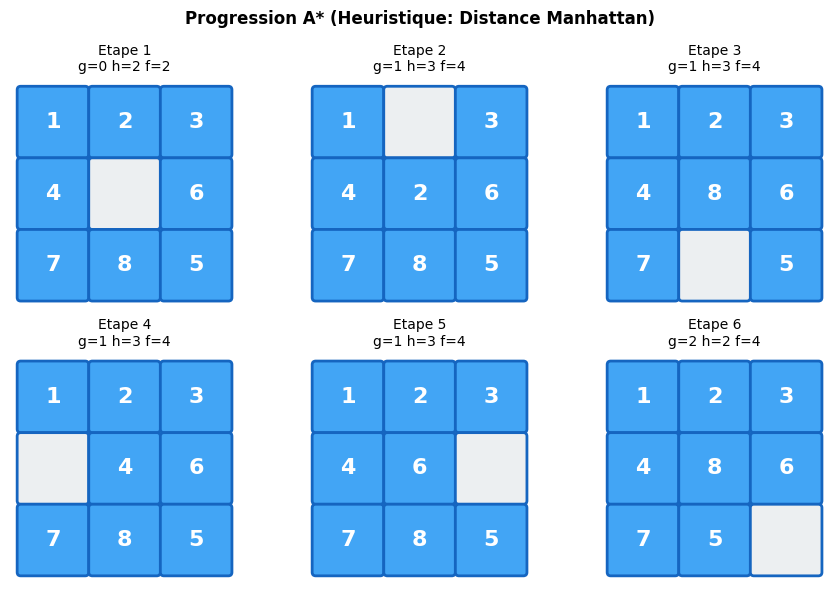

In [15]:
# --- Visualisation de l'exploration A* ---

def draw_puzzle_state(state, ax, title=""):
    """Dessine un etat du taquin."""
    for i in range(9):
        row, col = divmod(i, 3)
        value = state[i]

        if value == 0:
            color = '#ECEFF1'
            text = ''
        else:
            color = '#42A5F5'
            text = str(value)

        rect = mpatches.FancyBboxPatch(
            (col - 0.45, 2 - row - 0.45), 0.9, 0.9,
            boxstyle='round,pad=0.05',
            facecolor=color, edgecolor='#1565C0', linewidth=2
        )
        ax.add_patch(rect)
        if text:
            ax.text(col, 2 - row, text, ha='center', va='center',
                   fontsize=16, fontweight='bold', color='white')

    ax.set_xlim(-0.6, 2.6)
    ax.set_ylim(-0.6, 2.6)
    ax.set_aspect('equal')
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=10)


def visualize_astar_progression(problem, heuristic, max_steps=6):
    """Visualise la progression de A* pas a pas."""
    # Modifier A* pour capturer les etapes
    frontier = []
    counter = 0
    h_init = heuristic(problem.initial)
    root = Node(problem.initial, h=h_init)
    heapq.heappush(frontier, (root.f, counter, root))
    counter += 1

    g_scores = {root.state: 0}
    explored = set()
    steps = []

    while frontier and len(steps) < max_steps:
        f_val, _, node = heapq.heappop(frontier)

        if node.state in explored:
            continue

        steps.append({
            'state': node.state,
            'g': node.path_cost,
            'h': node.h,
            'f': node.f,
        })

        if problem.goal_test(node.state):
            break

        explored.add(node.state)

        for child in node.expand(problem, heuristic):
            if child.state not in explored:
                old_g = g_scores.get(child.state, float('inf'))
                if child.path_cost < old_g:
                    g_scores[child.state] = child.path_cost
                    heapq.heappush(frontier, (child.f, counter, child))
                    counter += 1

    # Afficher les etapes
    n = len(steps)
    fig, axes = plt.subplots(2, (n + 1) // 2, figsize=(3 * ((n + 1) // 2), 6))
    if n == 1:
        axes = [[axes[0]]]
    axes = axes.flatten()

    for i, step in enumerate(steps):
        title = f"Etape {i+1}\ng={step['g']} h={step['h']} f={step['f']}"
        draw_puzzle_state(step['state'], axes[i], title)

    # Masquer les axes inutilises
    for i in range(n, len(axes)):
        axes[i].axis('off')

    fig.suptitle('Progression A* (Heuristique: Distance Manhattan)',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualiser sur un probleme simple
simple_puzzle = EightPuzzleProblem((1, 2, 3, 4, 0, 6, 7, 8, 5))
visualize_astar_progression(simple_puzzle, h_manhattan, max_steps=6)

### Interpretation : Evolution de f(n) pendant la recherche

La visualisation montre comment A* explore les etats :

| Etape | g(n) | h(n) | f(n) | Signification |
|-------|------|------|------|---------------|
| 1 (Initial) | 0 | hauteur | f(0) | Estimation initiale |
| 2+ | croissant | variable | ~constant | A* tend a garder f croissant lentement |

**Observation** : A* explore d'abord les etats avec $f(n)$ faible. Quand il expand un noeud, il genere des fils avec $g$ augmente mais $h$ diminue (on se rapproche du but).

## 8. Tableau recapitulatif : Algorithmes informes vs non informes

Synthetisons nos connaissances en comparant tous les algorithmes etudies (Search-2 et Search-3).


Tableau recapitulatif : Algorithmes de recherche
Algorithme Complet Optimal Cout  Noeuds explores Temps (ms)
       BFS     Oui     Non 1075                2       0.03
       UCS     Oui     Oui 1075               10       0.06
    Greedy     Non     Non 1075                2       0.03
        A*     Oui     Oui 1075                3       0.02


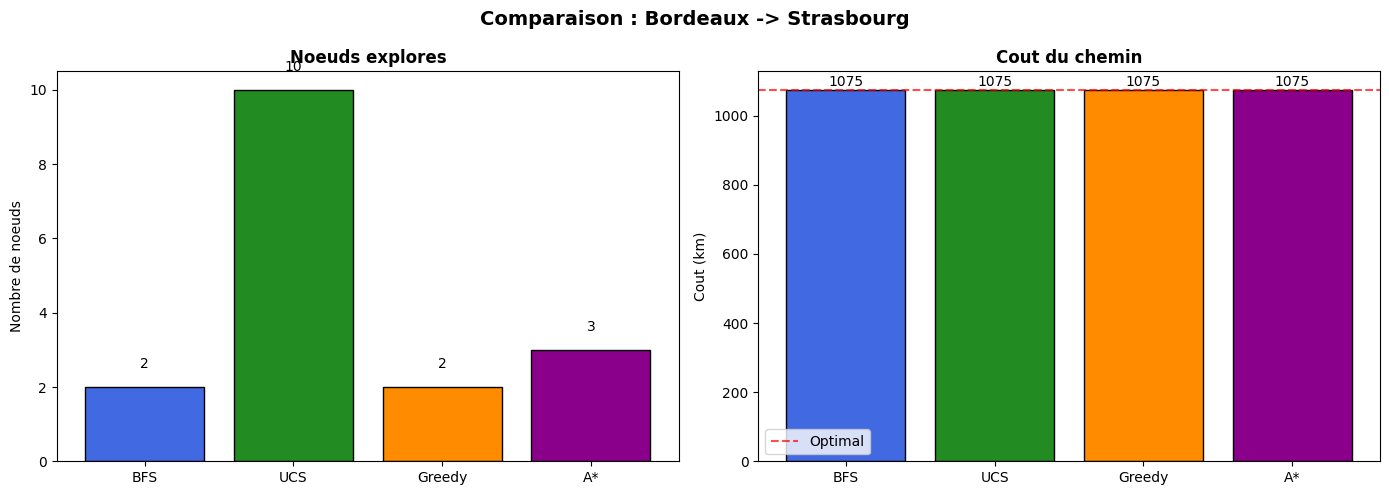

In [16]:
# --- Tableau recapitulatif complet ---

# Import des algorithmes non informes depuis Search-2
def breadth_first_search(problem, verbose=False):
    """BFS pour comparaison (implementation simplifiee)."""
    start_time = time.perf_counter()
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        elapsed = (time.perf_counter() - start_time) * 1000
        return SearchResult('BFS', node, 0, 0, 1, elapsed)

    frontier = deque([node])
    frontier_states = {node.state}
    explored = set()
    explored_order = []
    nodes_expanded = 0
    nodes_generated = 0
    max_frontier = 1

    while frontier:
        current = frontier.popleft()
        frontier_states.discard(current.state)
        explored.add(current.state)
        explored_order.append(current.state)
        nodes_expanded += 1

        for child in current.expand(problem):
            nodes_generated += 1
            if child.state not in explored and child.state not in frontier_states:
                if problem.goal_test(child.state):
                    elapsed = (time.perf_counter() - start_time) * 1000
                    return SearchResult('BFS', child, nodes_expanded,
                                        nodes_generated, max_frontier,
                                        elapsed, explored_order)
                frontier.append(child)
                frontier_states.add(child.state)
                max_frontier = max(max_frontier, len(frontier))

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('BFS', None, nodes_expanded, nodes_generated,
                        max_frontier, elapsed, explored_order)


def uniform_cost_search(problem, verbose=False):
    """UCS pour comparaison."""
    start_time = time.perf_counter()
    node = Node(problem.initial)
    frontier = []
    counter = 0
    heapq.heappush(frontier, (node.path_cost, counter, node))
    counter += 1
    frontier_map = {node.state: node.path_cost}
    explored = set()
    explored_order = []
    nodes_expanded = 0
    nodes_generated = 0
    max_frontier = 1

    while frontier:
        cost, _, current = heapq.heappop(frontier)

        if problem.goal_test(current.state):
            elapsed = (time.perf_counter() - start_time) * 1000
            return SearchResult('UCS', current, nodes_expanded,
                                nodes_generated, max_frontier,
                                elapsed, explored_order)

        if current.state in explored:
            continue

        explored.add(current.state)
        explored_order.append(current.state)
        nodes_expanded += 1

        for child in current.expand(problem):
            nodes_generated += 1
            if child.state not in explored:
                old_cost = frontier_map.get(child.state, float('inf'))
                if child.path_cost < old_cost:
                    heapq.heappush(frontier, (child.path_cost, counter, child))
                    counter += 1
                    frontier_map[child.state] = child.path_cost
                    max_frontier = max(max_frontier, len(frontier))

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('UCS', None, nodes_expanded, nodes_generated,
                        max_frontier, elapsed, explored_order)


# Comparer tous les algorithmes
test_problem = GraphProblem('Bordeaux', 'Strasbourg', france_graph)
h = make_heuristic('Strasbourg', france_coords)

results = {
    'BFS': breadth_first_search(test_problem),
    'UCS': uniform_cost_search(test_problem),
    'Greedy': greedy_best_first_search(test_problem, h),
    'A*': a_star_search(test_problem, h),
}

# Creer le tableau
summary_data = []
for name, result in results.items():
    summary_data.append({
        'Algorithme': name,
        'Complet': 'Oui' if name in ['BFS', 'UCS', 'A*'] else 'Non',
        'Optimal': 'Oui' if name in ['UCS', 'A*'] else 'Non',
        'Cout': f"{result.cost:.0f}",
        'Noeuds explores': result.nodes_expanded,
        'Temps (ms)': f"{result.elapsed_ms:.2f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\nTableau recapitulatif : Algorithmes de recherche")
print("=" * 80)
print(summary_df.to_string(index=False))

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Noeuds explores
names = list(results.keys())
explored_counts = [results[n].nodes_expanded for n in names]
colors = ['#4169E1', '#228B22', '#FF8C00', '#8B008B']
axes[0].bar(names, explored_counts, color=colors, edgecolor='black')
axes[0].set_ylabel('Nombre de noeuds')
axes[0].set_title('Noeuds explores', fontweight='bold')
for i, v in enumerate(explored_counts):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontsize=10)

# Cout du chemin
costs = [results[n].cost for n in names]
axes[1].bar(names, costs, color=colors, edgecolor='black')
axes[1].set_ylabel('Cout (km)')
axes[1].set_title('Cout du chemin', fontweight='bold')
for i, v in enumerate(costs):
    axes[1].text(i, v + 10, f"{v:.0f}", ha='center', fontsize=10)

# Marquer l'optimal
optimal_cost = min(costs)
axes[1].axhline(y=optimal_cost, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[1].legend()

plt.suptitle('Comparaison : Bordeaux -> Strasbourg', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : Synthese des algorithmes de recherche

**Tableau recapitulatif des proprietes** :

| Algorithme | Complet | Optimal | Strategie | Heuristique |
|------------|---------|---------|-----------|-------------|
| BFS | Oui | Oui* | Par niveaux | Non |
| DFS | Non | Non | En profondeur | Non |
| UCS | Oui | Oui | Par cout croissant | Non |
| IDDFS | Oui | Oui* | Profondeur iteree | Non |
| Greedy | Non | Non | Par $h(n)$ | Oui |
| A* | Oui | Oui** | Par $g(n)+h(n)$ | Oui |
| IDA* | Oui | Oui** | $f(n)$ iteree | Oui |

\* Optimal uniquement avec couts uniformes.
\*\* Optimal avec heuristique admissible.

**Guide de choix pratique** :

| Situation | Algorithme recommande |
|-----------|----------------------|
| Pas d'heuristique, couts uniformes | BFS ou IDDFS |
| Pas d'heuristique, couts variables | UCS |
| Heuristique disponible, assez de memoire | A* |
| Heuristique disponible, memoire limitee | IDA* |
| Solution rapide acceptable | Greedy |

## 9. Exercices

### Exercice 1 : Verifier l'admissibilite

Pour le probleme d'itineraire, verifiez que la distance a vol d'oiseau est bien une heuristique admissible. Pour cela, comparez la distance a vol d'oiseau avec la distance reelle pour plusieurs paires de villes.

In [17]:
# --- Exercice 1 : Verifier l'admissibilite ---

def check_admissibility(graph, coords):
    """
    Verifie que la distance a vol d'oiseau est admissible.
    Pour chaque paire de villes connectees, h(n) <= cout reel.
    """
    print("Verification de l'admissibilite de la distance a vol d'oiseau")
    print("=" * 70)
    print(f"{'Ville 1':<15} {'Ville 2':<15} {'h(n)':>10} {'Cout reel':>10} {'OK?':>8}")
    print("-" * 70)

    all_ok = True
    for city1, neighbors in graph.items():
        for city2, real_cost in neighbors.items():
            # Eviter les doublons
            if city1 < city2:
                h = euclidean_distance(city1, city2, coords)
                ok = h <= real_cost
                if not ok:
                    all_ok = False
                status = "OK" if ok else "NON"
                print(f"{city1:<15} {city2:<15} {h:>10.0f} {real_cost:>10.0f} {status:>8}")

    print("-" * 70)
    if all_ok:
        print("Conclusion : L'heuristique est ADMISSIBLE (h(n) <= cout reel pour toutes les paires)")
    else:
        print("Conclusion : L'heuristique N'EST PAS admissible !")


check_admissibility(france_graph, france_coords)

Verification de l'admissibilite de la distance a vol d'oiseau
Ville 1         Ville 2               h(n)  Cout reel      OK?
----------------------------------------------------------------------
Paris           Strasbourg             433        490       OK
Lyon            Paris                  397        465       OK
Lyon            Marseille              276        315       OK
Lyon            Strasbourg             390        490       OK
Marseille       Toulouse               316        405       OK
Marseille       Nice                   158        200       OK
Marseille       Montpellier            124        170       OK
Bordeaux        Paris                  504        585       OK
Bordeaux        Toulouse               212        245       OK
Bordeaux        Nantes                 276        340       OK
Nantes          Paris                  361        385       OK
Nantes          Rennes                  99        110       OK
Lille           Paris                  205      

---

<details>
<summary><b>Solution Exercice 1</b> (cliquez pour afficher)</summary>

La distance a vol d'oiseau est toujours inferieure ou egale a la distance routiere reelle car :
1. La ligne droite est le chemin le plus court entre deux points dans un plan
2. La distance routiere suit les infrastructures (routes, virages, detours)

Donc $h(n) \leq h^*(n)$ pour toute paire de villes : l'heuristique est **admissible**.

Note : Sur des distances tres courtes (centre-ville), la difference peut etre minime, mais l'inegalite reste verifiee.

</details>

### Exercice 2 : Creer une heuristique non admissible

Modifiez la distance a vol d'oiseau pour creer une heuristique non admissible (par exemple, en multipliant par 2). Observez comment A* se comporte avec cette heuristique. Trouve-t-il toujours une solution ? Est-elle optimale ?

In [18]:
# --- Exercice 2 : Heuristique non admissible ---

def make_inadmissible_heuristic(goal, coords, factor=2.0):
    """Cree une heuristique non admissible (multiplie la distance)."""
    def h(state):
        return factor * euclidean_distance(state, goal, coords)
    h.__name__ = f"h_inadmissible_x{factor}"
    return h

# Heuristique admissible (reference)
h_admissible = make_heuristic('Strasbourg', france_coords)

# Heuristique non admissible (x2)
h_inadmissible = make_inadmissible_heuristic('Strasbourg', france_coords, factor=2.0)

# Comparer A* avec les deux heuristiques
print("A* avec heuristique admissible vs non admissible")
print("=" * 70)

result_adm = a_star_search(problem_bs, h_admissible)
result_inadm = a_star_search(problem_bs, h_inadmissible)

print(f"\n{'Heuristique':<25} {'Cout':>8} {'Noeuds':>10} {'Optimal?':>10}")
print("-" * 70)
print(f"{'Admissible (vol d\'oiseau)':<25} {result_adm.cost:>8.0f} "
      f"{result_adm.nodes_expanded:>10} {'Oui':>10}")
print(f"{'Non admissible (x2)':<25} {result_inadm.cost:>8.0f} "
      f"{result_inadm.nodes_expanded:>10} ", end="")

if abs(result_inadm.cost - result_adm.cost) < 0.1:
    print(f"{'Oui (chance)':>10}")
else:
    print(f"{'Non':>10}")

print(f"\nNote : Avec une heuristique non admissible, A* n'est PAS garanti optimal !")

A* avec heuristique admissible vs non admissible

Heuristique                   Cout     Noeuds   Optimal?
----------------------------------------------------------------------
Admissible (vol d'oiseau)     1075          3        Oui
Non admissible (x2)           1075          2 Oui (chance)

Note : Avec une heuristique non admissible, A* n'est PAS garanti optimal !


### Exercice 3 : Heuristique pour un autre probleme

Soit un probleme de "tour de villes" ou l'objectif est de visiter toutes les villes exactement une fois (TSP). Proposez une heuristique admissible pour ce probleme et discutez ses proprietes.

**Indices** :
- Pensez a la structure du probleme (visiter toutes les villes)
- Une borne inferieure simple est le cout de l'arbre de recouvrement minimum (MST)
- Une autre borne est la somme des n/2 plus petites aretes

In [19]:
# --- Exercice 3 : Heuristique pour le TSP ---

def mst_heuristic(state, unvisited, graph):
    """
    Heuristique basee sur l'arbre de recouvrement minimum (MST).

    Pour un etat du TSP (ville actuelle + villes non visitees),
    le MST des villes restantes + connexion a la ville actuelle
    donne une borne inferieure admissible.

    Note : Implementation simplifiee avec l'algorithme de Prim.
    """
    if not unvisited:
        return 0

    # Tous les noeuds a connecter : ville actuelle + non visitees
    nodes = [state] + list(unvisited)

    # Algorithme de Prim pour le MST
    in_mst = {nodes[0]}
    mst_cost = 0
    edges = []

    # Initialiser les aretes depuis le premier noeud
    for node in nodes[1:]:
        if node in graph and nodes[0] in graph[node]:
            edges.append((graph[nodes[0]][node], nodes[0], node))

    while len(in_mst) < len(nodes):
        # Trouver l'arete minimale vers un noeud hors du MST
        edges.sort()
        found = False
        for cost, n1, n2 in edges:
            if n1 in in_mst and n2 not in in_mst:
                in_mst.add(n2)
                mst_cost += cost
                # Ajouter les nouvelles aretes depuis n2
                for node in nodes:
                    if node not in in_mst and node in graph and n2 in graph.get(n2, {}):
                        edges.append((graph[n2][node], n2, node))
                found = True
                break

        if not found:
            break

    return mst_cost


# Exemple d'utilisation
print("Heuristique MST pour le TSP (simplifiee)")
print("=" * 50)
print("Pour un probleme de TSP avec des villes non visitees :")
print("  L'heuristique MST est admissible car :")
print("  1. Le MST est le plus petit graphe connectant toutes les villes")
print("  2. Tout tour doit contenir un cycle connectant toutes les villes")
print("  3. Le cout du MST <= cout du cycle optimal")
print("\nAutres heuristiques admissibles pour le TSP :")
print("  - Somme des n/2 plus petites aretes")
print("  - Cout de connexion minimale de chaque ville non visitee")

Heuristique MST pour le TSP (simplifiee)
Pour un probleme de TSP avec des villes non visitees :
  L'heuristique MST est admissible car :
  1. Le MST est le plus petit graphe connectant toutes les villes
  2. Tout tour doit contenir un cycle connectant toutes les villes
  3. Le cout du MST <= cout du cycle optimal

Autres heuristiques admissibles pour le TSP :
  - Somme des n/2 plus petites aretes
  - Cout de connexion minimale de chaque ville non visitee


### Exercice 4 : A* avec visualisation sur grille

Implementez un probleme de pathfinding sur une grille 2D avec obstacles. Utilisez A* pour trouver le chemin et visualisez l'exploration.

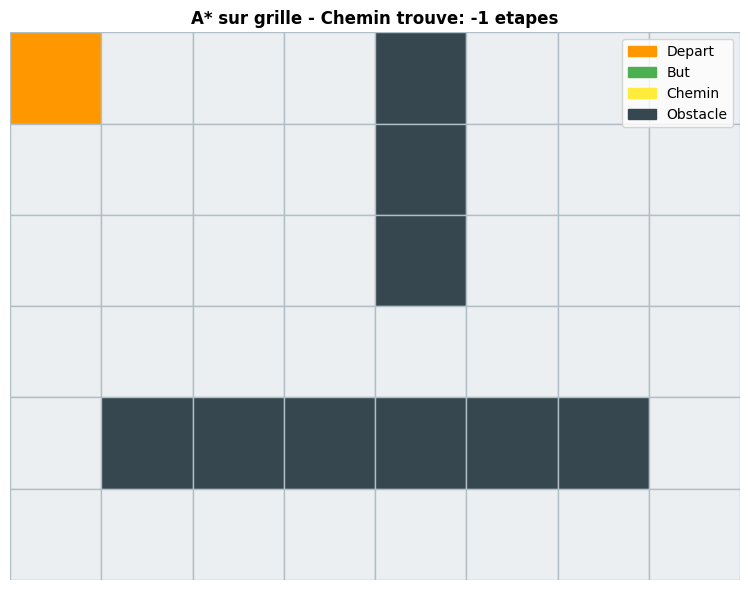

Pathfinding sur grille : (0, 0) -> (6, 7)
  Chemin : 
  Longueur : -1 etapes


In [20]:
# --- Exercice 4 : Pathfinding sur grille avec A* ---

class GridProblem(Problem):
    """Probleme de pathfinding sur une grille 2D avec obstacles."""

    def __init__(self, grid, start, goal):
        """
        grid: liste de listes, 0 = libre, 1 = obstacle
        start, goal: tuples (row, col)
        """
        self.grid = grid
        self.rows = len(grid)
        self.cols = len(grid[0])
        super().__init__(start, goal)

    def actions(self, state):
        row, col = state
        moves = []
        # Haut, Bas, Gauche, Droite
        for dr, dc, name in [(-1, 0, 'H'), (1, 0, 'B'), (0, -1, 'G'), (0, 1, 'D')]:
            nr, nc = row + dr, col + dc
            if 0 <= nr < self.rows and 0 <= nc < self.cols:
                if self.grid[nr][nc] == 0:  # Case libre
                    moves.append(name)
        return moves

    def result(self, state, action):
        row, col = state
        if action == 'H':
            return (row - 1, col)
        elif action == 'B':
            return (row + 1, col)
        elif action == 'G':
            return (row, col - 1)
        elif action == 'D':
            return (row, col + 1)
        return state


def manhattan_distance(state, goal):
    """Distance Manhattan pour la grille."""
    return abs(state[0] - goal[0]) + abs(state[1] - goal[1])


# Creer une grille simple
grid = [
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
]

start = (0, 0)
goal = (6, 7)

grid_problem = GridProblem(grid, start, goal)
h_grid = lambda s: manhattan_distance(s, goal)

# Resoudre avec A*
result_grid = a_star_search(grid_problem, h_grid)

# Visualiser
fig, ax = plt.subplots(figsize=(10, 6))

# Dessiner la grille
for r in range(len(grid)):
    for c in range(len(grid[0])):
        if grid[r][c] == 1:
            color = '#37474F'  # Obstacle
        elif (r, c) == start:
            color = '#FF9800'  # Start
        elif (r, c) == goal:
            color = '#4CAF50'  # Goal
        elif result_grid.found and (r, c) in result_grid.path:
            color = '#FFEB3B'  # Chemin
        else:
            color = '#ECEFF1'  # Libre

        rect = plt.Rectangle((c - 0.5, len(grid) - 1 - r - 0.5), 1, 1,
                             facecolor=color, edgecolor='#B0BEC5')
        ax.add_patch(rect)

# Marquer le chemin
if result_grid.found and len(result_grid.path) > 1:
    path_coords = [(c, len(grid) - 1 - r) for r, c in result_grid.path]
    path_x, path_y = zip(*path_coords)
    ax.plot(path_x, path_y, 'r-', linewidth=2, alpha=0.7)

ax.set_xlim(-0.5, len(grid[0]) - 0.5)
ax.set_ylim(-0.5, len(grid) - 0.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title(f'A* sur grille - Chemin trouve: {len(result_grid.path) - 1} etapes',
             fontsize=12, fontweight='bold')

# Legende
legend_patches = [
    mpatches.Patch(color='#FF9800', label='Depart'),
    mpatches.Patch(color='#4CAF50', label='But'),
    mpatches.Patch(color='#FFEB3B', label='Chemin'),
    mpatches.Patch(color='#37474F', label='Obstacle'),
]
ax.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()

print(f"Pathfinding sur grille : {start} -> {goal}")
print(f"  Chemin : {' -> '.join(map(str, result_grid.path))}")
print(f"  Longueur : {len(result_grid.path) - 1} etapes")

## 10. Conclusion

### Concepts cles

| Concept | Definition |
|---------|------------|
| **Heuristique $h(n)$** | Estimation du cout restant de $n$ au but |
| **Admissible** | $h(n) \leq h^*(n)$ (ne surestime jamais) |
| **Consistante** | $h(n) \leq c(n, n') + h(n')$ (monotone) |
| **Dominance** | $h_1 \geq h_2$ : $h_1$ est plus informee |
| **f(n) = g(n) + h(n)** | Fonction d'evaluation de A* |

### Algorithmes

| Algorithme | Critere | Optimal | Memoire |
|------------|----------|---------|----------|
| Greedy | Minimiser $h(n)$ | Non | $O(b^m)$ |
| A* | Minimiser $g(n) + h(n)$ | Oui (si $h$ admissible) | $O(b^d)$ |
| IDA* | DFS itere par $f(n)$ | Oui | $O(bd)$ |

### Ce qu'il faut retenir

1. **L'heuristique est la cle** : une bonne heuristique peut reduire l'explosion combinatoire de plusieurs ordres de grandeur
2. **A* est l'algo de reference** : optimal avec heuristique admissible, utilisable dans la plupart des cas
3. **Greedy pour la vitesse** : quand une solution "assez bonne" suffit
4. **IDA* pour la memoire** : meme optimalite que A*, avec une consommation lineaire
5. **La dominances** : une heuristique plus informee (dominante) explore toujours moins de noeuds

### Pour aller plus loin

- **Notebook suivant** : [Search-4-LocalSearch](Search-4-LocalSearch.ipynb) - Hill Climbing, Simulated Annealing, Tabu Search
- **Applications** : Voir [Sudoku-7-Norvig](../../Sudoku/Sudoku-7-Norvig.ipynb) pour l'application de la propagation de contraintes (inspiree de la recherche informee)
- **Reference** : Russell & Norvig, *Artificial Intelligence: A Modern Approach*, Chapitre 3.5 - Heuristic Functions

---

**Navigation** : [<< Recherche non informee](Search-2-Uninformed.ipynb) | [Index](../README.md) | [Recherche locale >>](Search-4-LocalSearch.ipynb)